# Import libraries and Data

In [2]:
from os import path
import logging
from datetime import datetime
from functools import reduce
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import importlib
from sklearn import metrics

import logReg
import modelScripts
importlib.reload(modelScripts)
from modelScripts import buildCategoricalDf
from modelScripts import detectCategoricalColumns
from modelScripts import generateCategories
from modelScripts import createScaledArray
from modelScripts import ordered_join
from modelScripts import daysSince
from modelScripts import daysSinceDf
from modelScripts import buildPivotColumn
from modelScripts import split
from modelScripts import dropLowInfo
from modelScripts import concatDf
from modelScripts import getSparseCases
from modelScripts import precisionRecall
import neuralNets as nn
from modelScripts import plot_confusion_matrix

class Init_Logger(object):

    def __init__(self, logger_name, filemode='w'):
        fn = logger_name + '.log'
        logging.basicConfig(filename=path.expandvars(fn), filemode=filemode,
                            level=logging.INFO)

    def info(self, message):
        logging.info(' {dt}: {msg}'.format(msg=message,
                                           dt=datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')))


def calcLogLoss(X, y, model):
    return metrics.log_loss(y, model.predict(X))

logger = Init_Logger('modelsBuild')
DATA_DIR = 'data'
TEST_SIZE = 0.3
LOW_INFO_THRESH = 0.001
CAT_PREFIX = 'cat_'
TARGET_COLUMN_NAME = 'y'

Using TensorFlow backend.


# Reload data if needed

In [2]:
logger.info('Reading raw data from disk')
df = pd.read_csv(path.join(DATA_DIR, 'dfTotal.csv'), index_col=['account_id'], low_memory=False)

logger.info('Substuting null values')
for c in df.columns.values:
    if c.startswith(CAT_PREFIX):
        df[c].fillna('nan', inplace=True)
    else:
        df[c].fillna(0, inplace=True)

logger.info('Splitting labels from data')
xColumns = [i for i in df.columns.values if i != TARGET_COLUMN_NAME]
dfX = df[xColumns]
dfY = df[[TARGET_COLUMN_NAME]]
del(df)

logger.info('Shape of the data is {}'.format(dfX.shape))
display(dfX.head())
logger.info('Number of null values in the dataframe is {}'.format(dfX.isnull().sum().sum()))

# Building scaled frame
logger.info('Starting to generate category dictionaries')
cat_dict = generateCategories(columns=list(xColumns), X=np.array(dfX),
                              categorical_prefix=CAT_PREFIX)

logger.info('Starting to generate scaled dataframe')
scaledDf = createScaledArray(X=dfX, dictionary=cat_dict, train=True)

logger.info('Dropping low info columns')
columnsToDrop = dropLowInfo(df=scaledDf, thresh=LOW_INFO_THRESH)
logger.info('Suggested columns to drop: \n {}'.format(columnsToDrop))
scaledDf.drop(columns=columnsToDrop, axis=1, inplace=True)

logger.info('Merging scaled dataset with labels and save on disk')
scaledDf = scaledDf.merge(right=dfY, right_index=True, left_index=True)
scaledDf.to_csv(path.join(DATA_DIR, 'scaledDf.csv'))
del(dfX)

logger.info('Shape of the scaled dataset: {}'.format(scaledDf.shape))

# sanity check:
for c in scaledDf.columns.values:
    if c.startswith(CAT_PREFIX):
        cases = scaledDf[c].value_counts().shape[0]
        list_1 = scaledDf[c].value_counts().index.values
        if len(np.setdiff1d(list_1,[0, 1])) > 0:
            print('{c}: cases = {cas}'.format(c=c, cas=cases))
            print(scaledDf[c].value_counts())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,cat_churn_reason_accounts,cat_time_diff_accounts,cat_paying_accounts,cat_device_accounts,cat_os_accounts,cat_browser_accounts,cat_payment_currency_accounts,cat_max_team_size_accounts,cat_min_team_size_accounts,cat_industry_accounts,...,cat_event_type_status_PAYMENT_METHOD_UPDATED_missing_subscriptions,cat_event_type_status_PLAN_ENFORCER_UPGRADE_missing_subscriptions,cat_event_type_status_RECURRING_missing_subscriptions,cat_event_type_status_REFUND_missing_subscriptions,cat_event_type_status_SUBSCRIPTION_CHARGE_FAILURE_missing_subscriptions,cat_event_type_status_USER_ADDED_missing_subscriptions,cat_event_type_status_USER_DELETED_missing_subscriptions,cat_event_type_status_other_subscriptions,cat_event_type_status_ONETIME_CHARGE_missing_subscriptions,mrr_gain_subscriptions
account_id,,,,,,,,,,,,,,,,,,,,,
1.0,nan,11.0,0,desktop,windows,microsoft edge,AUD,5.0,2.0,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0
2.0,nan,nan,0,mobile,ios,nan,USD,5.0,2.0,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0
3.0,nan,-6.0,0,desktop,windows,chrome,USD,1.0,1.0,Other,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0
4.0,nan,nan,0,mobile,android,nan,USD,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0
5.0,nan,-5.0,0,desktop,chrome_os,chrome,USD,1.0,1.0,Design,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0


# Data preparation

In [3]:
logger = Init_Logger('modelsBuild')
logger.info('Getting the data')

logger.info('Reading scaled data from the disk')
scaledDf = pd.read_csv(path.join(DATA_DIR, 'scaledDf.csv'), index_col=['account_id'])


def splitTarget(df, targetColName='y'):
    xColumns = [i for i in df.columns.values if i != targetColName]
    return df[xColumns], df[[targetColName]]


def buildDummies(df, targetColName='y'):
    return pd.get_dummies(df[targetColName])


scaledDfX, dfY = splitTarget(scaledDf)
    

logger.info('Getting train and test datasets')
X_train, X_test, y_train, y_test = \
    train_test_split(scaledDfX, dfY,  test_size=TEST_SIZE, random_state=0)

trainKeys = X_train.index.values.tolist()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Baseline models

## Lasso regression

In [4]:
DEFAULT_ALPHA = 0.00001
# Lasso regularization
PENALTY = 'l1'
MAX_INTER = 100
MODEL_TOL = None
SEED = None
LOG_LOSS = 'log'
JOBS = 8

def buildLogModel(X_Train, y_Train, alpha, penalty=PENALTY, lossFunction=LOG_LOSS, max_iter=MAX_INTER,
                  tol=MODEL_TOL, seed=SEED, n_jobs=JOBS):
    return logReg.modelBuild(alpha=alpha, lossFunction=lossFunction,
                             X=X_Train, Y=y_Train, penalty=penalty, max_iter=max_iter,
                             tol=tol, seed=seed, n_jobs=n_jobs)


def runLogModel(X_train, y_train, X_test, y_test, alpha=DEFAULT_ALPHA,
                pi=None, mu=None):
    y_test = buildDummies(y_test)
    y_train = buildDummies(y_train)
    classes = y_train.columns
    modelLog = buildLogModel(X_Train=X_train, y_Train=y_train.values[:, 1], alpha=alpha)
    pred = modelLog.predict_proba(X_test)
    
    if pi and mu:
        predScaled = np.array([rescaleBalancedProb(mu=mu, pi=pi, probPair=i) for i in pred])
    else:
        predScaled = pred
        

    loss = logReg.calcLogLoss(X=X_test, y=y_test.values[:, 1], model=modelLog)
    print('loss for baseline model: {}'.format(loss))
    print('Precision recall curve:')
    precisionRecall(pred=predScaled[:, 1], y=y_test.values[:, 1])
    plot_confusion_matrix(pred=predScaled, y=y_test.values, normalize=True, names=classes)
    plot_confusion_matrix(pred=predScaled, y=y_test.values, normalize=False, names=classes)
    return loss

loss for baseline model: 0.06815766905062938
Precision recall curve:


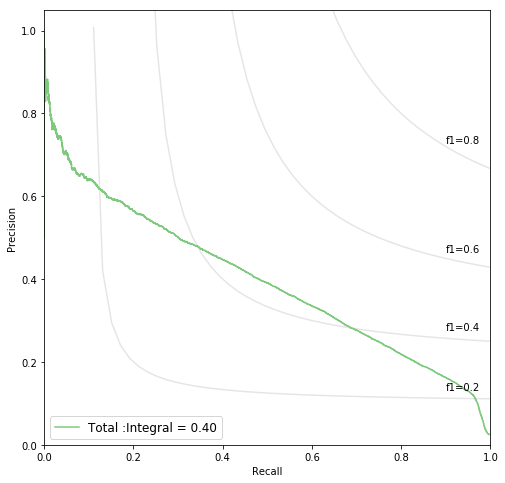

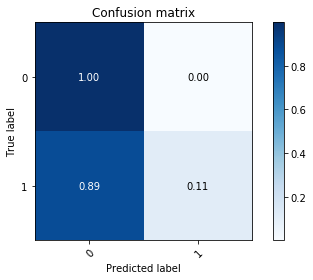

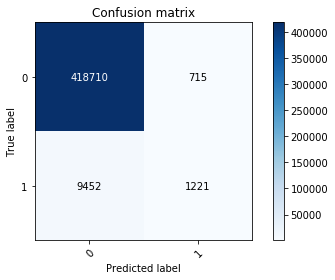

In [123]:
loss = runLogModel(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

## Neural network

In [7]:
nodes = [96,48,12,8]
KER_REG = 0.00001
PENALTY = 'l1'

checkpointfile = 'best_weights_baseline.hdf5'
def buildNNModel(X_Train, y_Train, X_Val, y_Val, nodes, olActivation='softmax',
                 lossFunction='binary_crossentropy',
                 checkpointFile=checkpointfile, ker_reg=KER_REG,
                 batch_size=500, epochs=300, early_stopping_delta=0.0001,
                 earlyStoppingDelta=0.0001, early_stopping_patience=10, dropout=0.001,
                 ker_reg_type=PENALTY):
    keras = nn.Keras(olActivation=olActivation, loss=lossFunction, 
                     inputDim=X_train.shape[1], outputDim=y_Train.shape[1])
    model = keras.modelBuild(nodes, X_Train, y_Train, X_Val, y_Val, checkpointFile=checkpointfile,
                             batch_size=batch_size, epochs=epochs,
                             early_stopping_delta=early_stopping_delta,
                             early_stopping_patience=early_stopping_patience,
                             dropout=dropout, ker_reg=ker_reg,
                             ker_reg_type=ker_reg_type)
    return model

def runNNmodel(X_train_part, y_train_part, X_val, y_val, nodes, X_test, y_test, 
               ker_reg=KER_REG, pi=None, mu=None, showOutput=True):
    y_val_dummies = buildDummies(y_val)
    y_train_part_dummies = buildDummies(y_train_part)
    y_test_dummies = buildDummies(y_test)
    classes = y_test_dummies.columns
    model = buildNNModel(X_Train=X_train_part, y_Train=y_train_part_dummies.values, X_Val=X_val,
                         y_Val=y_val_dummies.values, nodes=nodes, ker_reg=ker_reg)
    
    pred = model.predict(X_test)
    if pi and mu:
        predScaled = np.array([rescaleBalancedProb(mu=mu, pi=pi, probPair=i) for i in pred])
    else:
        predScaled = pred
    loss = metrics.log_loss(y_test_dummies.values, pred)
    
    if showOutput:
        print('loss for baseline model: {}'.format(loss))
        print('Precision recall curve:')
        precisionRecall(pred=pred[:, 1], y=y_test_dummies.values[:, 1])
        plot_confusion_matrix(pred=pred, y=y_test_dummies.values, normalize=True, names=classes)
        plot_confusion_matrix(pred=pred, y=y_test_dummies.values, normalize=False, names=classes)
    return {'model': model, 'loss': loss}

Train on 702491 samples, validate on 301068 samples
Epoch 1/300
 - 72s - loss: 0.0688 - acc: 0.9758 - val_loss: 0.0641 - val_acc: 0.9769
Epoch 2/300
 - 62s - loss: 0.0636 - acc: 0.9767 - val_loss: 0.0640 - val_acc: 0.9767
Epoch 3/300
 - 57s - loss: 0.0622 - acc: 0.9769 - val_loss: 0.0620 - val_acc: 0.9775
Epoch 4/300
 - 56s - loss: 0.0613 - acc: 0.9772 - val_loss: 0.0620 - val_acc: 0.9774
Epoch 5/300
 - 59s - loss: 0.0606 - acc: 0.9774 - val_loss: 0.0613 - val_acc: 0.9774
Epoch 6/300
 - 61s - loss: 0.0600 - acc: 0.9776 - val_loss: 0.0616 - val_acc: 0.9773
Epoch 7/300
 - 56s - loss: 0.0594 - acc: 0.9778 - val_loss: 0.0613 - val_acc: 0.9777
Epoch 8/300
 - 64s - loss: 0.0590 - acc: 0.9778 - val_loss: 0.0647 - val_acc: 0.9772
Epoch 9/300
 - 54s - loss: 0.0585 - acc: 0.9781 - val_loss: 0.0618 - val_acc: 0.9776
Epoch 10/300
 - 61s - loss: 0.0582 - acc: 0.9782 - val_loss: 0.0615 - val_acc: 0.9776
Epoch 11/300
 - 60s - loss: 0.0577 - acc: 0.9783 - val_loss: 0.0631 - val_acc: 0.9767
Epoch 12/30

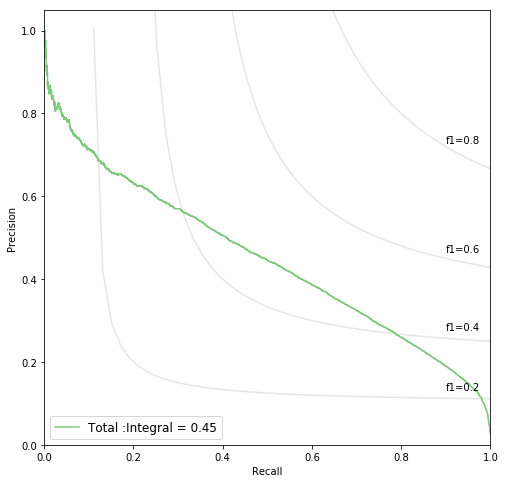

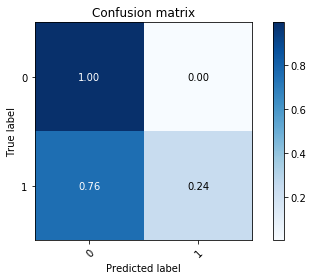

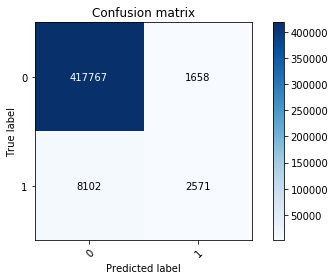

In [129]:
runNNmodel(X_train_part=X_train_part, y_train_part=y_train_part,
           X_val=X_val, y_val=y_val, nodes=nodes, X_test=X_test, y_test=y_test)

It seems that loosing VIP accounts is worse than giving extra attention to a regular one, lets try data balancing 

# Data Balancing

In [5]:
# Balance data for Training Set only

def rescaleBalancedProb(pi, mu, probPair):
    '''
    pi - probability of the event in the real dataset
    mu - probability of the event in the manufactured dataset
    p_manufuctured - probability calculated based on the manufactured dataset
    '''
    p_manufuctured = probPair[1]
    q_manufuctured = 1 - p_manufuctured
    rescale_1 = (pi * (1 - mu) * p_manufuctured)/((pi - mu) * p_manufuctured + mu * (1 - pi))
    return [1 - rescale_1, rescale_1]
    

def dataBalance(df, balanceRatio=1, targetColumnName=TARGET_COLUMN_NAME):
    XColumns = [c for c in df.columns.values if c != targetColumnName]
    print('original distribution of target values : \n {}'.
            format(df[targetColumnName].value_counts()))
    
    print('original dataset shape: \n {}'.
            format(df[XColumns].shape))

    # Original distribution for later
    ySum = df[targetColumnName].sum()
    yCnt = df[targetColumnName].count()
    balanceParams = {'pi': ySum/yCnt, 'mu': 1/(balanceRatio + 1)}

    # Randomly select rows corresponding to y = 0, based on y=1 frequency
    dfRandom = df.loc[df[targetColumnName] == 0].sample(ySum)
    
    balancedDf = pd.concat([df.loc[df[targetColumnName] == 1], dfRandom])
    print('balanced distribution of target values : \n {}'.
            format(balancedDf[targetColumnName].value_counts()))
    print('Balanced dataset shape: \n {}'.
            format(balancedDf.shape))
    return balancedDf, balanceParams


dfBalanced, balanceParams = dataBalance(df=scaledDf.loc[trainKeys])
dfBalancedX, dfBalancedY = splitTarget(dfBalanced)

original distribution of target values : 
 0    978543
1     25016
Name: y, dtype: int64
original dataset shape: 
 (1003559, 697)
balanced distribution of target values : 
 1    25016
0    25016
Name: y, dtype: int64
Balanced dataset shape: 
 (50032, 698)


## Lasso

loss for baseline model: 0.42782938443435475
Precision recall curve:


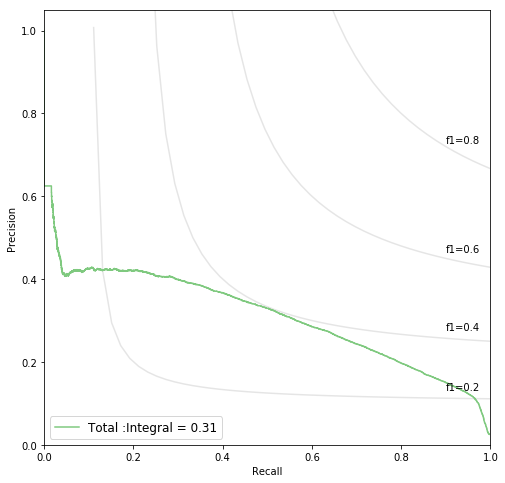

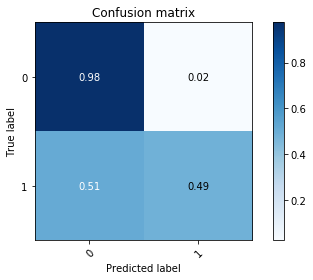

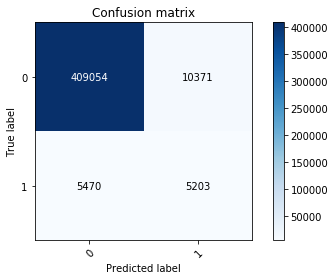

In [126]:
runLogModel(X_train=dfBalancedX, y_train=dfBalancedY, X_test=X_test, y_test=y_test,
            pi=balanceParams['pi'], mu=balanceParams['mu'])

## Neural Network

Train on 37524 samples, validate on 12508 samples
Epoch 1/300
 - 4s - loss: 0.5035 - acc: 0.7857 - val_loss: 0.3506 - val_acc: 0.8526
Epoch 2/300
 - 1s - loss: 0.3009 - acc: 0.8805 - val_loss: 0.2837 - val_acc: 0.8827
Epoch 3/300
 - 1s - loss: 0.2616 - acc: 0.8967 - val_loss: 0.2577 - val_acc: 0.8993
Epoch 4/300
 - 1s - loss: 0.2525 - acc: 0.9010 - val_loss: 0.2586 - val_acc: 0.8998
Epoch 5/300
 - 1s - loss: 0.2488 - acc: 0.9030 - val_loss: 0.2642 - val_acc: 0.8962
Epoch 6/300
 - 1s - loss: 0.2532 - acc: 0.9014 - val_loss: 0.2554 - val_acc: 0.9004
Epoch 7/300
 - 1s - loss: 0.2439 - acc: 0.9033 - val_loss: 0.3098 - val_acc: 0.8703
Epoch 8/300
 - 1s - loss: 0.2482 - acc: 0.9028 - val_loss: 0.2558 - val_acc: 0.9002
Epoch 9/300
 - 1s - loss: 0.2395 - acc: 0.9059 - val_loss: 0.2527 - val_acc: 0.9008
Epoch 10/300
 - 1s - loss: 0.2371 - acc: 0.9071 - val_loss: 0.2560 - val_acc: 0.9001
Epoch 11/300
 - 1s - loss: 0.2371 - acc: 0.9058 - val_loss: 0.2515 - val_acc: 0.9010
Epoch 12/300
 - 2s - los

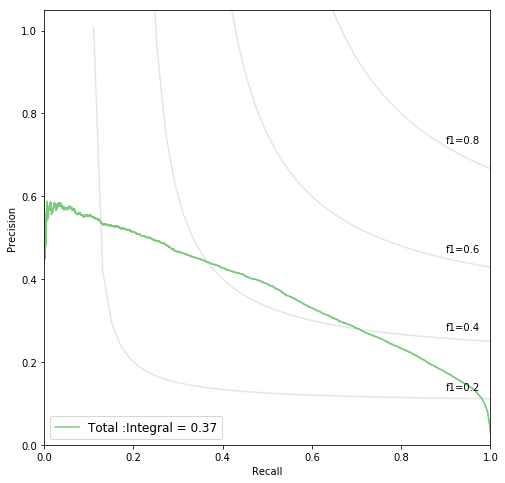

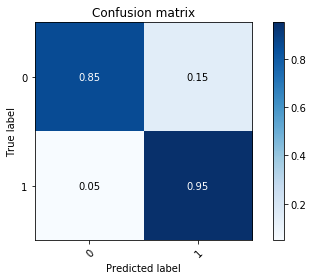

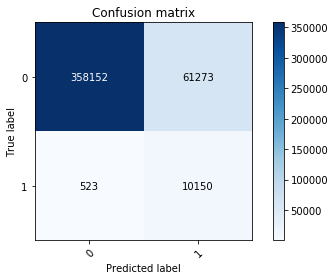

{'model': <keras.engine.sequential.Sequential at 0x84a499dd8>,
 'loss': 0.31118513185532476}

In [20]:
nodes = [96,48,12,8]
KER_REG = 0.00001

logger.info('Getting validation datasets for balanced data')
X_train_part_bal, X_val_bal, y_train_part_bal, y_val_bal = \
    train_test_split(dfBalancedX, dfBalancedY)

runNNmodel(X_train_part=X_train_part_bal, y_train_part=y_train_part_bal,
           X_val=X_val_bal, y_val=y_val_bal, nodes=nodes, X_test=X_test, y_test=y_test,
           pi=balanceParams['pi'], mu=balanceParams['mu'])

# k-Fold cross validation

## Neural network

In [8]:
from sklearn.model_selection import StratifiedKFold

def nnValidation(X_Train, y_Train, X_Test, y_Test, paramsDict, 
                 pi=None, mu=None, folds=4):
    results = {}
    kf = StratifiedKFold(folds, shuffle=True, random_state=42)
    for i, v in params.items():
        lossLst = []
        nodes = v['nodes'] 
        alpha = v['alpha']
        for train, test in kf.split(X_Train, y_Train):
            X_Train_A = X_Train.iloc[train]
            y_Train_A = y_Train.iloc[train]

            X_val = X_Train.iloc[test]
            y_val = y_Train.iloc[test]

            result = runNNmodel(X_train_part=X_Train_A,
                                y_train_part=y_Train_A,
                                X_val=X_val,
                                y_val=y_val,
                                nodes=nodes,
                                X_test=X_test, y_test=y_test, showOutput=False, ker_reg=alpha,
                                pi=pi, mu=mu)
            lossLst.append(result['loss'])
        results[i] = sum(lossLst) / len(lossLst)
        print('For param id = {id}, the result is {res}'.format(id=i, res=results[i]))
    return results

In [ ]:
# Find best structure
params = {
    1: {'nodes': [200,96,48,12,8], 'alpha': 0.00001}, 
    2: {'nodes': [200,48,12,8], 'alpha': 0.00001},
    3: {'nodes': [200,12,8], 'alpha': 0.00001},
    4: {'nodes': [200,8], 'alpha': 0.00001},
    5: {'nodes': [200], 'alpha': 0.00001},
    6: {'nodes': [96,48,12,8], 'alpha': 0.00001},
    7: {'nodes': [48,12,8], 'alpha': 0.00001},
    8: {'nodes': [12,8], 'alpha': 0.00001},
}

results_nodes = nnValidation(X_Train=dfBalancedX, y_Train=dfBalancedY,
                       X_Test=X_test, y_Test=y_test, paramsDict=params,
                       pi=balanceParams['pi'], mu=balanceParams['mu'])

In [14]:
minLoss = -1
for i, v, in params.items():
    if results_nodes[i] < minLoss or minLoss == -1:
        minLoss = results_nodes[i]
        bestNodes = v['nodes']

alphaParams = {
    1: {'alpha': 0.01}, 
    2: {'alpha': 0.001},
    3: {'alpha': 0.0001},
    4: {'alpha': 0.00001},
    5: {'alpha': 0.000001}
}

for i, v in alphaParams.items():
    v['nodes'] = bestNodes

In [ ]:
results_alpha =\
    nnValidation(X_Train=dfBalancedX, y_Train=dfBalancedY,
                 X_Test=X_test, y_Test=y_test, paramsDict=alphaParams,
                 pi=balanceParams['pi'], mu=balanceParams['mu'])


minLoss = -1
for i, v, in alphaParams.items():
    if results_alpha[i] < minLoss or minLoss == -1:
        minLoss = results_alpha[i]
        bestAlpha = v['alpha']

print('Best Alpha {a}; Best nodes: {n}'.format(a=bestAlpha, n=bestNodes))

Train on 37524 samples, validate on 12508 samples
Epoch 1/300
 - 8s - loss: 0.5174 - acc: 0.7530 - val_loss: 0.3693 - val_acc: 0.8419
Epoch 2/300
 - 2s - loss: 0.3121 - acc: 0.8738 - val_loss: 0.2837 - val_acc: 0.8858
Epoch 3/300
 - 2s - loss: 0.2605 - acc: 0.8971 - val_loss: 0.2658 - val_acc: 0.8953
Epoch 4/300
 - 2s - loss: 0.2495 - acc: 0.9019 - val_loss: 0.2677 - val_acc: 0.8896
Epoch 5/300
 - 2s - loss: 0.2473 - acc: 0.9021 - val_loss: 0.2777 - val_acc: 0.8866
Epoch 6/300
 - 2s - loss: 0.2482 - acc: 0.9014 - val_loss: 0.2604 - val_acc: 0.8973
Epoch 7/300
 - 2s - loss: 0.2427 - acc: 0.9046 - val_loss: 0.2615 - val_acc: 0.8963
Epoch 8/300
 - 2s - loss: 0.2417 - acc: 0.9038 - val_loss: 0.2641 - val_acc: 0.8919
Epoch 9/300
 - 2s - loss: 0.2390 - acc: 0.9042 - val_loss: 0.2571 - val_acc: 0.8957
Epoch 10/300
 - 2s - loss: 0.2378 - acc: 0.9051 - val_loss: 0.2583 - val_acc: 0.8949
Epoch 11/300
 - 2s - loss: 0.2342 - acc: 0.9067 - val_loss: 0.2575 - val_acc: 0.8969
Epoch 12/300
 - 2s - los

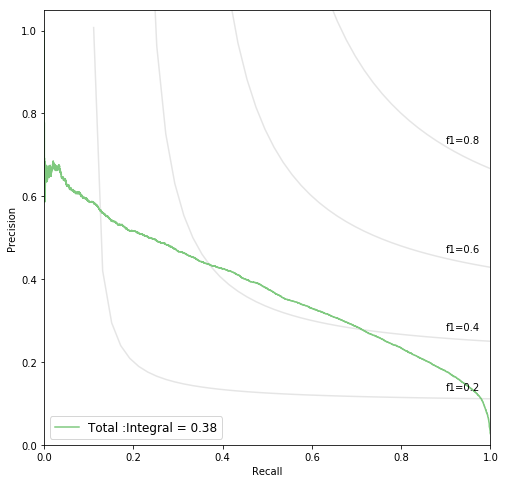

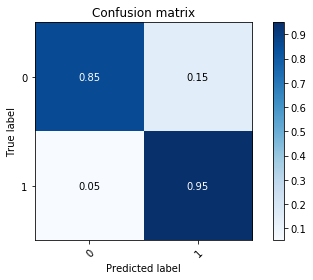

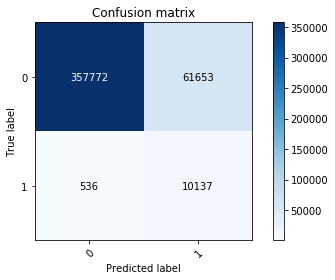

{'model': <keras.engine.sequential.Sequential at 0x12ff8c0f0>,
 'loss': 0.3085452027965949}

In [18]:
# Best Alpha 1e-05; Best nodes: [48, 12, 8]

X_train_part_bal, X_val_bal, y_train_part_bal, y_val_bal = \
    train_test_split(dfBalancedX, dfBalancedY)

runNNmodel(X_train_part=X_train_part_bal, y_train_part=y_train_part_bal,
           X_val=X_val_bal, y_val=y_val_bal, nodes=bestNodes, X_test=X_test, y_test=y_test,
           pi=balanceParams['pi'], mu=balanceParams['mu'], ker_reg=bestAlpha)

## Unbalanced data kfold

In [ ]:
# Find best structure
params = {
    1: {'nodes': [200,96,48,12,8], 'alpha': 0.00001}, 
    2: {'nodes': [200,48,12,8], 'alpha': 0.00001},
    3: {'nodes': [200,12,8], 'alpha': 0.00001},
    4: {'nodes': [200,8], 'alpha': 0.00001},
    5: {'nodes': [200], 'alpha': 0.00001},
    6: {'nodes': [96,48,12,8], 'alpha': 0.00001},
    7: {'nodes': [48,12,8], 'alpha': 0.00001},
    8: {'nodes': [12,8], 'alpha': 0.00001},
}

results_nodes = nnValidation(X_Train=X_train, y_Train=y_train,
                             X_Test=X_test, y_Test=y_test, paramsDict=params,
                             pi=None, mu=None)

minLoss = -1
for i, v, in params.items():
    if results_nodes[i] < minLoss or minLoss == -1:
        minLoss = results_nodes[i]
        bestNodes = v['nodes']

alphaParams = {
    1: {'alpha': 0.01}, 
    2: {'alpha': 0.001},
    3: {'alpha': 0.0001},
    4: {'alpha': 0.00001},
    5: {'alpha': 0.000001}
}


for i, v in alphaParams.items():
    v['nodes'] = bestNodes

results_alpha =\
    nnValidation(X_Train=X_train, y_Train=y_train,
                 X_Test=X_test, y_Test=y_test, paramsDict=alphaParams,
                 pi=None, mu=None)


minLoss = -1
for i, v, in alphaParams.items:
    if results_alpha[i] < minLoss or minLoss == -1:
        minLoss = results_alpha[i]
        bestAlpha = v['alpha']

print('Best Alpha {a}; Best nodes: {n}'.format(a=bestAlpha, n=bestNodes))

Train on 1003559 samples, validate on 301068 samples
Epoch 1/300
 - 70s - loss: 0.0742 - acc: 0.9760 - val_loss: 0.0637 - val_acc: 0.9768
Epoch 2/300
 - 56s - loss: 0.0636 - acc: 0.9768 - val_loss: 0.0620 - val_acc: 0.9773
Epoch 3/300
 - 58s - loss: 0.0622 - acc: 0.9771 - val_loss: 0.0616 - val_acc: 0.9772
Epoch 4/300
 - 57s - loss: 0.0613 - acc: 0.9774 - val_loss: 0.0611 - val_acc: 0.9773
Epoch 5/300
 - 63s - loss: 0.0607 - acc: 0.9775 - val_loss: 0.0603 - val_acc: 0.9779
Epoch 6/300
 - 60s - loss: 0.0602 - acc: 0.9776 - val_loss: 0.0594 - val_acc: 0.9781
Epoch 7/300
 - 56s - loss: 0.0598 - acc: 0.9778 - val_loss: 0.0591 - val_acc: 0.9779
Epoch 8/300
 - 52s - loss: 0.0593 - acc: 0.9780 - val_loss: 0.0585 - val_acc: 0.9782
Epoch 9/300
 - 57s - loss: 0.0588 - acc: 0.9782 - val_loss: 0.0584 - val_acc: 0.9785
Epoch 10/300
 - 56s - loss: 0.0582 - acc: 0.9784 - val_loss: 0.0570 - val_acc: 0.9789
Epoch 11/300
 - 56s - loss: 0.0579 - acc: 0.9785 - val_loss: 0.0570 - val_acc: 0.9791
Epoch 12/3

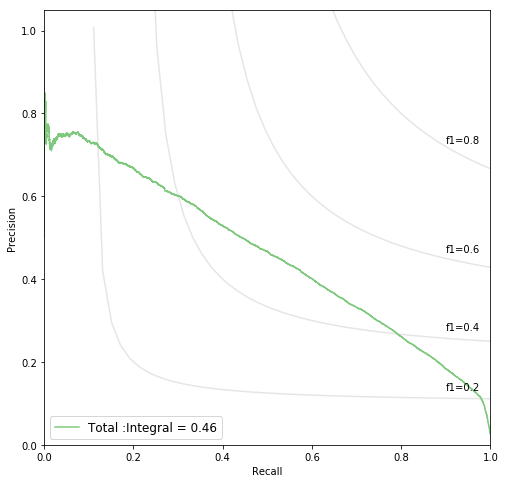

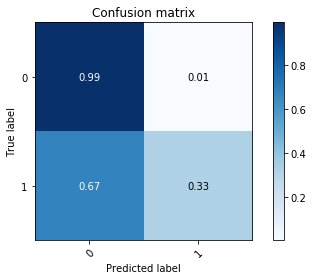

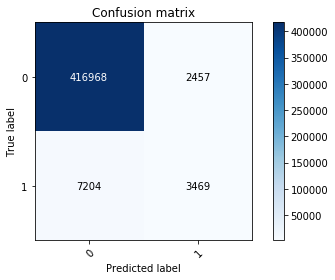

{'model': <keras.engine.sequential.Sequential at 0x13a1b9128>,
 'loss': 0.062419215268439895}

In [12]:
logger.info('Getting validation datasets')
X_train_part, X_val, y_train_part, y_val = \
    train_test_split(X_train, y_train,  test_size=TEST_SIZE, random_state=0)

bestAlpha = 1e-05
bestNodes = [48, 12, 8]
runNNmodel(X_train_part=X_train, y_train_part=y_train,
           X_val=X_val, y_val=y_val, nodes=bestNodes, X_test=X_test, y_test=y_test,
           pi=None, mu=None, ker_reg=bestAlpha)